In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm
import os

In [6]:
base_path = '../dataset'
df = pd.read_csv(f"{base_path}/line_index.tsv", sep='\t', names=["filename", "original_text"], index_col=1)
df.head()

,filename,original_text
NaN,khm_0308_0011865648,ស្ពាន កំពង់ ចម្លង អ្នកលឿង នៅ ព្រៃវែង ជា ស្ពាន ...
NaN,khm_0308_0032157149,ភ្លើង កំពុង ឆាប ឆេះ ផ្ទះ ប្រជា ពលរដ្ឋ នៅ សង្កា...
NaN,khm_0308_0038959268,អ្នក សុំ ទាន ដេក ប្រកាច់ ម្នាក់ ឯង ក្បែរ ខ្លោង...
NaN,khm_0308_0054635313,ស្ករ ត្នោត ដែល មាន គុណភាព ល្អ ផលិត នៅ ខេត្ត កំ...
NaN,khm_0308_0055735195,ភ្នំបាខែង មាន កម្ពស់ តែ ចិត សិប ម៉ែត្រ សោះ


### Audio Preprocessing

In [9]:
def process_audio_files(input_dir, output_dir):
    for index, row in tqdm(df.iterrows(), desc="Processing", leave=False):
        try:
            audio_path = os.path.join(input_dir, f"{row['filename']}.wav")
            output_path = os.path.join(output_dir, f"{row['filename']}_mel.npy")

            # Load and process audio
            waveform, sample_rate = librosa.load(audio_path, sr=22050)
            waveform = waveform / max(abs(waveform))  # Normalize
            waveform, _ = librosa.effects.trim(waveform)  # Trim silence

            # Compute Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(
                y=waveform, sr=sample_rate, n_fft=1024, hop_length=256, n_mels=80
            )
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Save as .npy
            np.save(output_path, mel_spectrogram_db)

        except RuntimeError as e:
            print(f"Error in batch: {e}")
            continue

    print("Audio processing completed!")

# Example usage
# process_audio_files(f"{base_path}/wavs/", f"{base_path}/mels/")

Audio processing completed!


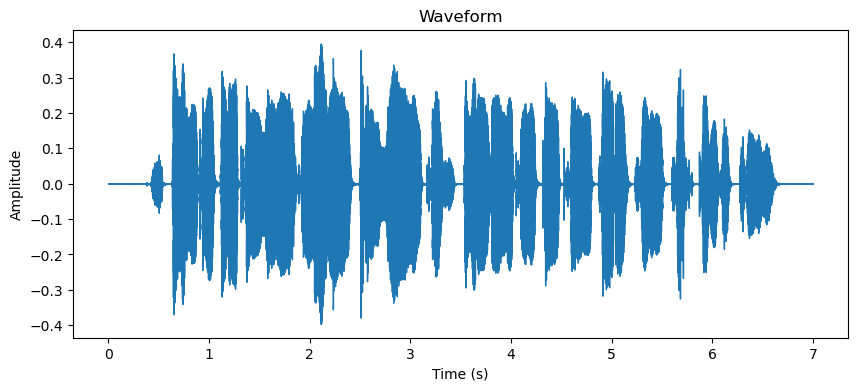

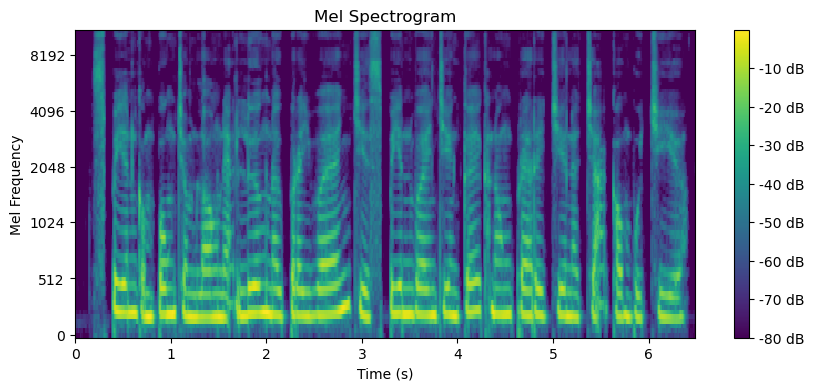

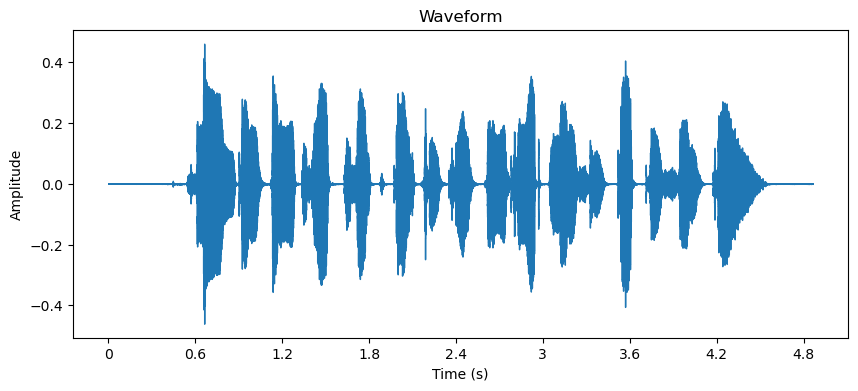

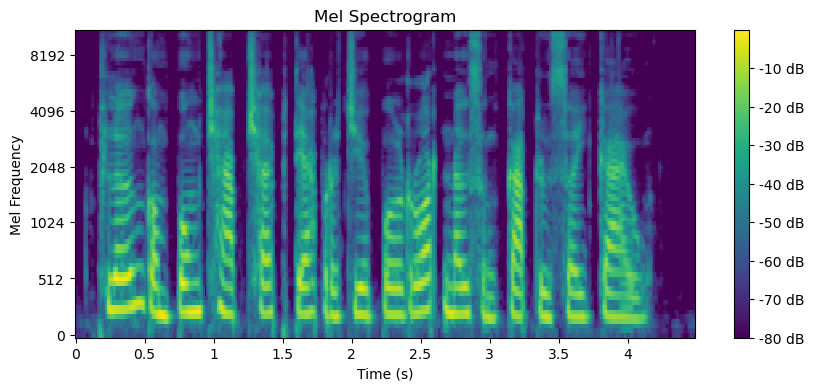

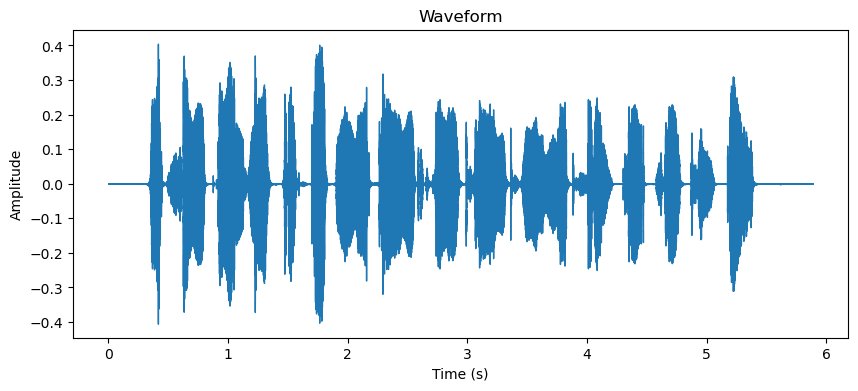

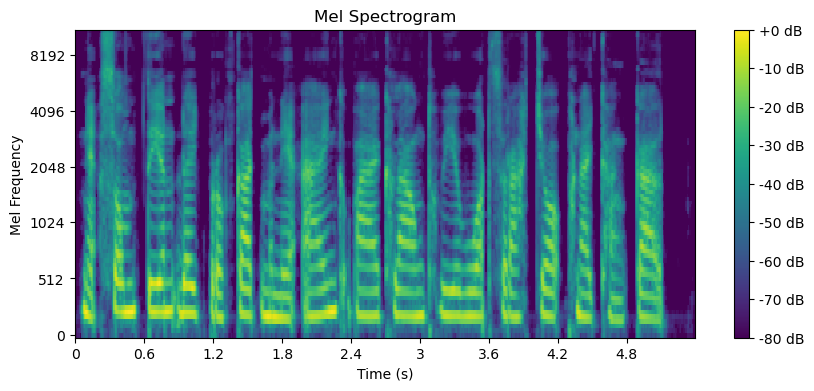

In [11]:
def validate_mel_spectrogram(n_batch=3):
    count = 1
    for idx, row in df.iterrows():
        if count > n_batch:
          break

        # Load the original waveform
        audio_path = f"{base_path}/wavs/{row['filename']}.wav"
        waveform, sr = librosa.load(audio_path, sr=22050)

        # Load the Mel spectrogram
        mel_path = f"{base_path}/mels/{row['filename']}_mel.npy"
        mel_spectrogram = np.load(mel_path)

        # Plot the waveform
        plt.figure(figsize=(10, 4))
        plt.title("Waveform")
        librosa.display.waveshow(waveform, sr=sr)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.show()

        # Plot the Mel spectrogram
        plt.figure(figsize=(10, 4))
        plt.title("Mel Spectrogram")
        librosa.display.specshow(mel_spectrogram, sr=sr, hop_length=256, x_axis='time', y_axis='mel', cmap='viridis')
        plt.colorbar(format="%+2.0f dB")
        plt.xlabel("Time (s)")
        plt.ylabel("Mel Frequency")
        plt.show()

        count+=1
        print("\n")

validate_mel_spectrogram()

### Verify Dataset

In [3]:
import pickle
from pprint import pprint

with open(f'{base_path}/dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

pprint(dataset[:5], compact=True)  # Print the first 5 entries

[('khm_0308_0054635313', 375), ('khm_0308_0038959268', 508),
 ('khm_0308_0011865648', 603), ('khm_0308_0032157149', 419),
 ('khm_0308_0055735195', 309)]


### Vocoder

In [2]:
import sys
import os

import torch.version

print(os.path.abspath(os.path.join('..', 'WaveRNN/models')))
sys.path.append(os.path.abspath(os.path.join('..', 'WaveRNN')))

import torch
from models.fatchord_version import WaveRNN
from utils.dsp import *
from utils.display import simple_table
from utils import hparams as hp
import numpy as np
import IPython
from pathlib import Path

d:\Code Files\Python\Data Science\Khmer-TTS\WaveRNN\models


In [8]:
print(torch.version.cuda)  # CUDA version PyTorch was built with
print(torch.cuda.is_available())  # Verify CUDA availability
print(torch.backends.cudnn.enabled)  # Check cuDNN compatibility

if not hp.is_configured():
    hp.configure(os.path.abspath(os.path.join('..', 'WaveRNN/hparams.py')))

batched = hp.voc_gen_batched
samples = hp.voc_gen_at_checkpoint
target = hp.voc_target
overlap = hp.voc_overlap

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Using device:', device)

print('\nInitialising Model...\n')

vocoder = WaveRNN(rnn_dims=hp.voc_rnn_dims,
                    fc_dims=hp.voc_fc_dims,
                    bits=hp.bits,
                    pad=hp.voc_pad,
                    upsample_factors=hp.voc_upsample_factors,
                    feat_dims=hp.num_mels,
                    compute_dims=hp.voc_compute_dims,
                    res_out_dims=hp.voc_res_out_dims,
                    res_blocks=hp.voc_res_blocks,
                    hop_length=hp.hop_length,
                    sample_rate=hp.sample_rate,
                    mode=hp.voc_mode
                ).to(device)

vocoder.load(os.path.abspath(os.path.join('..', 'WaveRNN/checkpoints/ljspeech_mol.wavernn/latest_weights.pyt')))

# print(vocoder)
simple_table([('Generation Mode', 'Batched' if batched else 'Unbatched'),
                  ('Target Samples', target if batched else 'N/A'),
                  ('Overlap Samples', overlap if batched else 'N/A')])

12.4
True
True
Using device: cuda

Initialising Model...

Trainable Parameters: 4.234M
+-----------------+----------------+-----------------+
| Generation Mode | Target Samples | Overlap Samples |
+-----------------+----------------+-----------------+
|     Batched     |     11000      |       550       |
+-----------------+----------------+-----------------+
 


In [4]:
def gen_from_file(model: WaveRNN, load_path: Path, save_path: Path, batched, target, overlap):

    k = model.get_step() // 1000
    file_name = load_path.stem

    suffix = load_path.suffix
    if suffix == ".wav":
        wav = load_wav(load_path)
        save_wav(wav, save_path/f'__{file_name}__{k}k_steps_target.wav')
        mel = melspectrogram(wav)
    elif suffix == ".npy":
        mel = np.load(load_path)
        if mel.ndim != 2 or mel.shape[0] != hp.num_mels:
            raise ValueError(f'Expected a numpy array shaped (n_mels, n_hops), but got {wav.shape}!')
        _max = np.max(mel)
        _min = np.min(mel)
        if _max >= 1.01 or _min <= -0.01:
            raise ValueError(f'Expected spectrogram range in [0,1] but was instead [{_min}, {_max}]')
    else:
        raise ValueError(f"Expected an extension of .wav or .npy, but got {suffix}!")


    mel = torch.tensor(mel).unsqueeze(0)

    batch_str = f'gen_batched_target{target}_overlap{overlap}' if batched else 'gen_NOT_BATCHED'
    save_str = save_path/f'__{file_name}__{k}k_steps_{batch_str}.wav'

    output = model.generate(mel, save_str, batched, target, overlap, hp.mu_law)
    return output

In [9]:
file = Path(f"{base_path}/mel/khm_0308_0011865648.npy")
output_path = Path('../outputs')

res = gen_from_file(vocoder, file, output_path, batched, target, overlap)

| ████████████████ 168000/169400 | Batch Size: 14 | Gen Rate: 7.2kHz | 